# MUSHROOMS

## Binary Classification

### Imports

In [225]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

### Load Data

In [226]:
DATA_PATH = '../DATA/'
FILE_NAME = 'mushrooms.csv'
def load_data(data_path=DATA_PATH, file_name=FILE_NAME):
    csv_path = os.path.join(data_path, file_name)
    return pd.read_csv(csv_path)

dataset = load_data()

### View Data and Informations

In [227]:
dataset.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [228]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [229]:
edible, poisonous = dataset['class'].value_counts()

print("Edible:\t  ", edible,"\nPoisonous:", poisonous)

Edible:	   4208 
Poisonous: 3916


In [230]:
# Categorical to numerical
labels = {'e': 0, 'p': 1}
dataset['class'].replace(labels, inplace=True)

edible, poisonous = dataset['class'].value_counts()
print("0 - Edible:   ", edible,"\n1 - Poisonous:", poisonous)

0 - Edible:    4208 
1 - Poisonous: 3916


# NN1 Stalk Root - Rooted (r)

### Split Dataset

#### Get the Labels

In [231]:
X, y =  dataset.drop('class', axis=1), dataset['class'].copy()

print("X:",X.shape,"\ny:",y.shape)

X: (8124, 22) 
y: (8124,)


#### Train Set and Test Set

In [232]:
from sklearn.model_selection import train_test_split
X_white = pd.DataFrame()
X_not_white = pd.DataFrame()
y_white = pd.Series(dtype='float64')
y_not_white = pd.Series(dtype='float64')
for i in range(0,len(X)):
    if X.loc[i,"stalk-root"] == "r":
        X_white = X_white.append(X.iloc[i,:])
        y_white = y_white.append(pd.Series(y.iloc[i]))
    else:
        X_not_white = X_not_white.append(X.iloc[i,:])
        y_not_white = y_not_white.append(pd.Series(y.iloc[i]))

In [233]:
X_train_not_white, X_test_not_white, y_train_not_white, y_test_not_white = train_test_split(X_not_white, y_not_white, test_size=1-(6905/(8124-len(X_white))), random_state=37)

# print(X_test_white)
X_train_white = (X_train_not_white)
# X_test_white = X_white.append(X_test_not_white)
y_train_white = (y_train_not_white)
# y_test_white = y_white.append(y_test_not_white)

In [234]:
from sklearn.utils import shuffle
X_train_full1 = shuffle(X_train_white, random_state=37)
X_test = shuffle(X, random_state=37).iloc[2000:4000]
y_train_full1 = shuffle(y_train_white, random_state=37)
y_test = shuffle(y, random_state=37).iloc[2000:4000]

In [235]:
# print(X_test[:5])
# print(y_test.loc[:,"0"])
# from sklearn.model_selection import train_test_split

# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=37)

# print("85% - X_train size:", X_train_full.shape[0], " y_train size:", y_train_full.shape[0])
# print("15% - X_test size: ", X_test.shape[0], " y_test size: ", y_test.shape[0])

#### Validation Set

In [236]:
X_valid1, X_train1 = X_train_full1[:500], X_train_full1[500:]
y_valid1, y_train1 = y_train_full1[:500], y_train_full1[500:]

print("X_train:", X_train1.shape[0], "y_train", y_train1.shape[0])
print("X_valid: ", X_valid1.shape[0], "y_valid ", y_valid1.shape[0])
print("X_test: ", X_test.shape[0], "y_test ", X_test.shape[0])


X_train: 6404 y_train 6404
X_valid:  500 y_valid  500
X_test:  2000 y_test  2000


### Prepare the Data

#### Data Transformation

In [237]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

cat_attr_pipeline = Pipeline([
                        ('encoder', OrdinalEncoder())
                    ])

cols = list(X)
pipeline = ColumnTransformer([
                ('cat_attr_pipeline', cat_attr_pipeline, cols)
            ])


X_train1 = pipeline.fit_transform(X_train1)
X_valid1 = pipeline.fit_transform(X_valid1)
X_test1  = pipeline.fit_transform(X_test)

### Neural Network

#### Model

In [238]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

In [239]:
tf.random.set_random_seed(37)

In [240]:
model1 = Sequential([
    InputLayer(input_shape=(22,)),    # input  layer
    Dense(45, activation='relu'),     # hidden layer
    Dense(1,   activation='sigmoid')  # output layer
])

In [241]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 45)                1035      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 46        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


#### Compile the Model

In [242]:
model1.compile(loss='binary_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

#### Prepare Callbacks

In [243]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint('../SavedModels/best_model.h5',
                                save_best_only=True)

early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True)

### Training

In [244]:
train_model1 = model1.fit(X_train1, y_train1,
                        epochs=100,
                        validation_data=(X_valid1, y_valid1),
                        callbacks=[checkpoint_cb, early_stopping_cb])
                        


Train on 6404 samples, validate on 500 samples
Epoch 1/100
6404/6404 [==============================] - 1s 124us/sample - loss: 0.4640 - acc: 0.7900 - val_loss: 0.4018 - val_acc: 0.8480
Epoch 2/100
6404/6404 [==============================] - 0s 52us/sample - loss: 0.3173 - acc: 0.8841 - val_loss: 0.3203 - val_acc: 0.8720
Epoch 3/100
6404/6404 [==============================] - 0s 62us/sample - loss: 0.2729 - acc: 0.9044 - val_loss: 0.2991 - val_acc: 0.8920
Epoch 4/100
6404/6404 [==============================] - 0s 43us/sample - loss: 0.2474 - acc: 0.9122 - val_loss: 0.2637 - val_acc: 0.8840
Epoch 5/100
6404/6404 [==============================] - 0s 50us/sample - loss: 0.2251 - acc: 0.9190 - val_loss: 0.3855 - val_acc: 0.8360
Epoch 6/100
6404/6404 [==============================] - 0s 65us/sample - loss: 0.2121 - acc: 0.9249 - val_loss: 0.2222 - val_acc: 0.9100
Epoch 7/100
6404/6404 [==============================] - 0s 50us/sample - loss: 0.1960 - acc: 0.9305 - val_loss: 0.5633 - va

### Evaluate the Best Model on Test Set

In [245]:
results1 = model1.evaluate(X_test1, y_test)
print("test loss, test acc:", results1)

2000/2000 [==============================] - 0s 37us/sample - loss: 0.1439 - acc: 0.9430
test loss, test acc: [0.1438773773908615, 0.943]


### Make Some Predictions

In [246]:
X_new1 = X_test1[:5]
y_prob1 = model1.predict(X_new1)
# print(y_prob.round(3))

In [247]:
y_pred1 = (model1.predict(X_new1) > 0.5).astype("int32")
# print(y_pred)
y_test_pred = (model1.predict(X_test1) > 0.5).astype("int32")

## KL Divergence

In [248]:
# X_new = X_test[:5]
X_df1 = pd.DataFrame(model1.predict(X_test1))
y_test_pred1 = pd.DataFrame(y_test_pred).reset_index(drop=True)
X_df1 = pd.concat([X_df1, y_test_pred1], axis=1)
y_test1 = y_test.reset_index(drop=True)
X_df1 = pd.concat([X_df1, y_test1], axis=1)
X_df1.columns = ["X_pred","y_pred","y_actual"]
print(X_df1)

        X_pred  y_pred  y_actual
0     0.979996       1         1
1     0.895362       1         1
2     0.866164       1         1
3     0.734473       1         1
4     0.958439       1         1
...        ...     ...       ...
1995  0.805070       1         1
1996  0.997322       1         1
1997  0.391174       0         1
1998  0.007026       0         0
1999  0.985243       1         1

[2000 rows x 3 columns]


In [249]:
import math
table1 = pd.DataFrame(columns=["KL_div","abs_distance","correctness"])
for i in range(0,len(X_df1)):
    # KL divergence
    p = X_df1.loc[i,"X_pred"]
    try:
        kl = -(p*math.log(p) + (1-p)*math.log(1-p))
    except:
        kl = 0
    table1.loc[i,"KL_div"] = kl
    # absolute distance
    abs_dist = 2*abs(0.5-p)
    table1.loc[i,"abs_distance"] = abs_dist
    # correctness
    y_pred1 = X_df1.loc[i,"y_pred"]
    y_act1 = X_df1.loc[i,"y_actual"]
    if y_pred1 == y_act1:
        table1.loc[i,"correctness"] = 1 # correct prediction
    else:
        table1.loc[i,"correctness"] = 0 # wrong prediction
    table1.loc[i,"y_pred"] = y_pred1

print(table1)

        KL_div abs_distance correctness  y_pred
0     0.098054     0.959992           1     1.0
1     0.335157     0.790723           1     1.0
2     0.393614     0.732329           1     1.0
3     0.578759     0.468946           1     1.0
4     0.172874     0.916878           1     1.0
...        ...          ...         ...     ...
1995  0.493294     0.610139           1     1.0
1996  0.018534     0.994645           1     1.0
1997  0.669271     0.217651           0     0.0
1998  0.041836     0.985949           1     0.0
1999  0.076863     0.970486           1     1.0

[2000 rows x 4 columns]


In [250]:
table1["count"] = 1
correctness1 = table1[["correctness","count"]].groupby(pd.cut(table1["KL_div"], np.arange(0, 0.8, 0.1))).apply(sum)
correctness1["percent"] = 100*(correctness1["correctness"]/correctness1["count"])
print(correctness1)

            correctness  count     percent
KL_div                                    
(0.0, 0.1]          720    720  100.000000
(0.1, 0.2]          516    518   99.613900
(0.2, 0.3]          276    282   97.872340
(0.3, 0.4]          147    154   95.454545
(0.4, 0.5]          100    117   85.470085
(0.5, 0.6]           54     81   66.666667
(0.6, 0.7]           73    128   57.031250


Text(0, 0.5, '% correct')

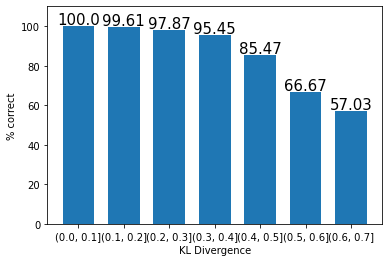

In [251]:
index = []
for i in (correctness1.index):
    index.append(str(i))
plt.bar(index,correctness1["percent"], width=0.7)
for index,data in enumerate(correctness1["percent"]):
    plt.text(x=index , y =data+1 , s=f"{round(data,2)}" , fontdict=dict(fontsize=15),ha='center')
plt.ylim(0,110)
plt.xlabel("KL Divergence")
plt.ylabel("% correct")

### Confidence

Text(0, 0.5, '% correct')

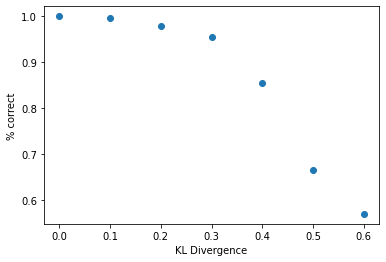

In [252]:
kl1 = table1[["correctness","count"]].groupby(pd.cut(table1["KL_div"], np.arange(0, 0.80, 0.1))).apply(sum)
kl1["percent"] = (kl1["correctness"]/kl1["count"])
kl1.dropna(inplace=True)
plt.scatter(np.arange(0, 0.70, 0.1), kl1["percent"])
plt.xlabel("KL Divergence")
plt.ylabel("% correct")

In [253]:
# Linear Regression
from sklearn.linear_model import LinearRegression

x_reg1 = np.arange(0, 0.70, 0.1).reshape((-1, 1))
y_reg1 = kl1["percent"]
reg_model1 = LinearRegression().fit(x_reg1,y_reg1)

In [254]:
print('intercept(alpha):', reg_model1.intercept_)
print('slope(theta):', reg_model1.coef_)

intercept(alpha): 1.082158593954519
slope(theta): [-0.74001061]


# NN2 Odor - Almond (a)

#### Train Set and Test Set

In [255]:
from sklearn.model_selection import train_test_split
X_green = pd.DataFrame()
X_not_green = pd.DataFrame()
y_green = pd.Series(dtype='float64')
y_not_green = pd.Series(dtype='float64')
for i in range(0,len(X)):
    if X.loc[i,"odor"] == "a":
        X_green = X_green.append(X.iloc[i,:])
        y_green = y_green.append(pd.Series(y.iloc[i]))
    else:
        X_not_green = X_not_green.append(X.iloc[i,:])
        y_not_green = y_not_green.append(pd.Series(y.iloc[i]))

In [256]:
# X_test_green, X_train_green, y_test_green, y_train_green = train_test_split(X_green, y_green, test_size=1, random_state=37)
X_train_not_green, X_test_not_green, y_train_not_green, y_test_not_green = train_test_split(X_not_green, y_not_green, test_size=1-(6905/(8124-len(X_green))), random_state=37)

# print(X_test_green)
X_train_green = (X_train_not_green)
X_test_green = X_green.append(X_test_not_green)
y_train_green = (y_train_not_green)
y_test_green = y_green.append(y_test_not_green)

In [257]:
from sklearn.utils import shuffle
X_train_full2 = shuffle(X_train_green, random_state=37)
# X_test2 = shuffle(X_test_green, random_state=37)
y_train_full2 = shuffle(y_train_green, random_state=37)
# y_test2 = shuffle(y_test_green, random_state=37)

#### Validation Set

In [258]:
X_valid2, X_train2 = X_train_full2[:500], X_train_full2[500:]
y_valid2, y_train2 = y_train_full2[:500], y_train_full2[500:]

print("X_train:", X_train2.shape[0], "y_train", y_train2.shape[0])
print("X_valid: ", X_valid2.shape[0], "y_valid ", y_valid2.shape[0])
print("X_test: ", X_test.shape[0], "y_test ", X_test.shape[0])


X_train: 6404 y_train 6404
X_valid:  500 y_valid  500
X_test:  2000 y_test  2000


### Prepare the Data

#### Data Transformation

In [259]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

cat_attr_pipeline = Pipeline([
                        ('encoder', OrdinalEncoder())
                    ])

cols = list(X)
pipeline = ColumnTransformer([
                ('cat_attr_pipeline', cat_attr_pipeline, cols)
            ])


X_train2 = pipeline.fit_transform(X_train2)
X_valid2 = pipeline.fit_transform(X_valid2)
X_test2  = pipeline.fit_transform(X_test)
y_test2 = y_test

### Neural Network

#### Model

In [260]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense

In [261]:
tf.random.set_random_seed(37)

In [262]:
model2 = Sequential([
    InputLayer(input_shape=(22,)),    # input  layer
    Dense(45, activation='relu'),     # hidden layer
    Dense(1,   activation='sigmoid')  # output layer
])

In [263]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 45)                1035      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 46        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


#### Compile the Model

In [264]:
model2.compile(loss='binary_crossentropy',
             optimizer='sgd',
             metrics=['accuracy'])

#### Prepare Callbacks

In [265]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint('../SavedModels/best_model.h5',
                                save_best_only=True)

early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True)

### Training

In [266]:
train_model2 = model2.fit(X_train2, y_train2,
                        epochs=100,
                        validation_data=(X_valid2, y_valid2),
                        callbacks=[checkpoint_cb, early_stopping_cb])
                        


Train on 6404 samples, validate on 500 samples
Epoch 1/100
6404/6404 [==============================] - 1s 184us/sample - loss: 0.4080 - acc: 0.8415 - val_loss: 0.3221 - val_acc: 0.8880
Epoch 2/100
6404/6404 [==============================] - 0s 51us/sample - loss: 0.2856 - acc: 0.9079 - val_loss: 0.2908 - val_acc: 0.8800
Epoch 3/100
6404/6404 [==============================] - 0s 45us/sample - loss: 0.2464 - acc: 0.9188 - val_loss: 0.2366 - val_acc: 0.9280
Epoch 4/100
6404/6404 [==============================] - 0s 59us/sample - loss: 0.2215 - acc: 0.9232 - val_loss: 0.2203 - val_acc: 0.9140
Epoch 5/100
6404/6404 [==============================] - ETA: 0s - loss: 0.2062 - acc: 0.925 - 0s 57us/sample - loss: 0.2049 - acc: 0.9265 - val_loss: 0.1967 - val_acc: 0.9400
Epoch 6/100
6404/6404 [==============================] - 0s 65us/sample - loss: 0.1899 - acc: 0.9333 - val_loss: 0.1874 - val_acc: 0.9440
Epoch 7/100
6404/6404 [==============================] - 0s 60us/sample - loss: 0.1780

### Evaluate the Best Model on Test Set

In [267]:
results2 = model2.evaluate(X_test2, y_test2)
print("test loss, test acc:", results2)

2000/2000 [==============================] - 0s 36us/sample - loss: 0.1863 - acc: 0.9330
test loss, test acc: [0.18632307776808738, 0.933]


### Make Some Predictions

In [268]:
X_new2 = X_test2[1100:1110]
y_prob2 = model2.predict(X_new2)
# print(y_prob2.round(3))

In [269]:
y_pred2 = (model2.predict(X_new2) > 0.5).astype("int32")
# print(y_pred2)
y_test_pred2 = (model2.predict(X_test2) > 0.5).astype("int32")

## KL Divergence

In [270]:
# X_new = X_test[:5]
X_df2 = pd.DataFrame(model2.predict(X_test2))
y_test_pred2 = pd.DataFrame(y_test_pred2).reset_index(drop=True)
X_df2 = pd.concat([X_df2, y_test_pred2], axis=1)
y_test2 = y_test2.reset_index(drop=True)
X_df2 = pd.concat([X_df2, y_test2], axis=1)
X_df2.columns = ["X_pred","y_pred","y_actual"]
print(X_df2)

        X_pred  y_pred  y_actual
0     0.999979       1         1
1     0.932437       1         1
2     0.784315       1         1
3     0.901394       1         1
4     0.922961       1         1
...        ...     ...       ...
1995  0.719968       1         1
1996  0.998294       1         1
1997  0.290893       0         1
1998  0.001422       0         0
1999  0.997806       1         1

[2000 rows x 3 columns]


In [271]:
import math
table2 = pd.DataFrame(columns=["KL_div","abs_distance","y_pred","correctness"])
for i in range(0,len(X_df2)):
    # KL divergence
    p = X_df2.loc[i,"X_pred"]
    kl = -(p*math.log(p) + (1-p)*math.log(1-p))
    table2.loc[i,"KL_div"] = kl
    # absolute distance
    abs_dist = 2*abs(0.5-p)
    table2.loc[i,"abs_distance"] = abs_dist
    # correctness
    y_pred = X_df2.loc[i,"y_pred"]
    y_act = X_df2.loc[i,"y_actual"]
    if y_pred == y_act:
        table2.loc[i,"correctness"] = 1 # correct prediction
    else:
        table2.loc[i,"correctness"] = 0 # wrong prediction
    table2.loc[i,"y_pred"] = y_pred

print(table2)

        KL_div abs_distance y_pred correctness
0     0.000249     0.999958      1           1
1     0.247288     0.864875      1           1
2     0.521392     0.568631      1           1
3      0.32201     0.802787      1           1
4     0.271477     0.845922      1           1
...        ...          ...    ...         ...
1995  0.592984     0.439935      1           1
1996  0.012577     0.996588      1           1
1997  0.602949     0.418214      0           0
1998  0.010744     0.997156      0           1
1999  0.015624     0.995612      1           1

[2000 rows x 4 columns]


In [272]:
table2["count"] = 1
correctness2 = table2[["correctness","count"]].groupby(pd.cut(table2["KL_div"], np.arange(0, 0.8, 0.1))).apply(sum)
correctness2["percent"] = 100*(correctness2["correctness"]/correctness2["count"])
print(correctness2)

            correctness  count    percent
KL_div                                   
(0.0, 0.1]         1164   1168  99.657534
(0.1, 0.2]          243    260  93.461538
(0.2, 0.3]          139    161  86.335404
(0.3, 0.4]          101    117  86.324786
(0.4, 0.5]           67     94  71.276596
(0.5, 0.6]           75     87  86.206897
(0.6, 0.7]           77    113  68.141593


Text(0, 0.5, '% correct')

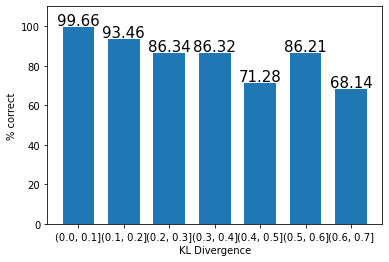

In [273]:
index = []
for i in (correctness2.index):
    index.append(str(i))
plt.bar(index,correctness2["percent"], width=0.7)
for index,data in enumerate(correctness2["percent"]):
    plt.text(x=index , y =data+1 , s=f"{round(data,2)}" , fontdict=dict(fontsize=15),ha='center')
plt.ylim(0,110)
plt.xlabel("KL Divergence")
plt.ylabel("% correct")

### Confidence

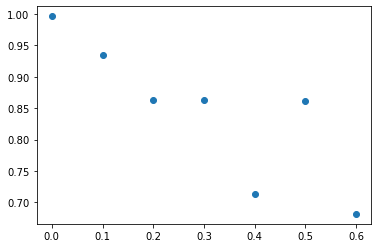

In [274]:
kl2 = table2[["correctness","count"]].groupby(pd.cut(table2["KL_div"], np.arange(0, 0.8, 0.1))).apply(sum)
kl2["percent"] = (kl2["correctness"]/kl2["count"])
kl2.dropna(inplace=True)
plt.scatter(np.arange(0, 0.70, 0.1), kl2["percent"])
# print(kl)
# print(np.arange(0, 0.7, 0.05))

In [275]:
# Linear Regression
from sklearn.linear_model import LinearRegression

x_reg2 = np.arange(0, 0.7, 0.1).reshape((-1, 1))
y_reg2 = kl2["percent"]
reg_model2 = LinearRegression().fit(x_reg2,y_reg2)

In [276]:
print('intercept(alpha):', reg_model2.intercept_)
print('slope(theta):', reg_model2.coef_)

intercept(alpha): 0.9778446925880102
slope(theta): [-0.44327113]


## Algorithm C: It = argmax(Ct,i)

In [277]:
# Correct answer
ans = pd.DataFrame(X_df2["y_actual"])

# NN1
alpha1 = reg_model1.intercept_
theta1 = reg_model1.coef_

# NN2
alpha2 = reg_model2.intercept_
theta2 = reg_model2.coef_

In [299]:
kl_div_table1 = table1[["correctness","count"]].groupby(pd.cut(table1["KL_div"], np.arange(0, 0.8, 0.05))).apply(sum)
kl_div_table1["percent"] = (kl_div_table1["correctness"]/kl_div_table1["count"])

kl_div_table2 = table2[["correctness","count"]].groupby(pd.cut(table2["KL_div"], np.arange(0, 0.8, 0.05))).apply(sum)
kl_div_table2["percent"] = (kl_div_table2["correctness"]/kl_div_table2["count"])
print(kl_div_table2)

             correctness  count   percent
KL_div                                   
(0.0, 0.05]        935.0  935.0  1.000000
(0.05, 0.1]        229.0  233.0  0.982833
(0.1, 0.15]        134.0  144.0  0.930556
(0.15, 0.2]        109.0  116.0  0.939655
(0.2, 0.25]         85.0   98.0  0.867347
(0.25, 0.3]         54.0   63.0  0.857143
(0.3, 0.35]         63.0   68.0  0.926471
(0.35, 0.4]         38.0   49.0  0.775510
(0.4, 0.45]         35.0   44.0  0.795455
(0.45, 0.5]         32.0   50.0  0.640000
(0.5, 0.55]         45.0   52.0  0.865385
(0.55, 0.6]         30.0   35.0  0.857143
(0.6, 0.65]         27.0   36.0  0.750000
(0.65, 0.7]         50.0   77.0  0.649351
(0.7, 0.75]          0.0    0.0       NaN


In [305]:
# Creating NN tables
nn1 = table1.drop(["abs_distance","correctness"], axis=1)
nn1["conf"] = 1 + theta1 * nn1["KL_div"]

# for i in range(0,len(nn1)):
#     nn1.loc[i,"conf"] = kl_div_table1.loc[nn1.loc[i,"KL_div"],"percent"]

nn2 = table2.drop(["abs_distance","correctness"], axis=1)
nn2["conf"] = 1 + theta2 * nn2["KL_div"]

# for i in range(0,len(nn2)):
#     nn2.loc[i,"conf"] = kl_div_table2.loc[nn2.loc[i,"KL_div"],"percent"]
nn1

,KL_div,y_pred,count,conf
0,0.098054,1.0,1,0.927439
1,0.335157,1.0,1,0.75198
2,0.393614,1.0,1,0.708722
3,0.578759,1.0,1,0.571712
4,0.172874,1.0,1,0.872072
...,...,...,...,...
1995,0.493294,1.0,1,0.634958
1996,0.018534,1.0,1,0.986285
1997,0.669271,0.0,1,0.504733
1998,0.041836,0.0,1,0.969041


In [306]:
# Determing higher confidence NN and choosing that arm

for i in range(0,len(nn1)):
    if nn1.loc[i,"conf"] > nn2.loc[i,"conf"]:
        ans.loc[i,"y_pred"] = nn1.loc[i,"y_pred"]
        ans.loc[i,"chosen_NN"] = 1
        ans.loc[i,"chosen_conf"] = nn1.loc[i,"conf"]

        ans.loc[i,"not_NN"] = 2
        ans.loc[i,"not_conf"] = nn2.loc[i,"conf"]
    else:
        ans.loc[i,"y_pred"] = nn2.loc[i,"y_pred"]
        ans.loc[i,"chosen_NN"] = 2
        ans.loc[i,"chosen_conf"] = nn2.loc[i,"conf"]

        ans.loc[i,"not_NN"] = 1
        ans.loc[i,"not_conf"] = nn1.loc[i,"conf"]

ans

,y_actual,y_pred,chosen_NN,chosen_conf,not_NN,not_conf
0,1,1.0,2.0,0.999890,1.0,0.927439
1,1,1.0,2.0,0.890384,1.0,0.751980
2,1,1.0,2.0,0.768882,1.0,0.708722
3,1,1.0,2.0,0.857262,1.0,0.571712
4,1,1.0,2.0,0.879662,1.0,0.872072
...,...,...,...,...,...,...
1995,1,1.0,2.0,0.737147,1.0,0.634958
1996,1,1.0,2.0,0.994425,1.0,0.986285
1997,1,0.0,2.0,0.732730,1.0,0.504733
1998,0,0.0,2.0,0.995237,1.0,0.969041


#### Comparing performance

In [307]:
wrong_record = ""
# NN1 performance
cost1 = 0
for i in range(0,len(nn1)):
    if nn1.loc[i,"y_pred"] != ans.loc[i,"y_actual"]:
        cost1 += 1 * nn1.loc[i,"conf"]
    else:
        pass

# NN2 performance
cost2 = 0
for i in range(0,len(nn2)):
    if nn2.loc[i,"y_pred"] != ans.loc[i,"y_actual"]:
        cost2 += 1 * nn2.loc[i,"conf"]
    else:
        pass

# Combined performance
cost3 = 0
for i in range(0,len(nn1)):
    chosen_nn = int(ans.loc[i,"chosen_NN"])
    chosen_nn_conf = round(ans.loc[i,"chosen_conf"],3)
    not_nn = int(ans.loc[i,"not_NN"])
    not_nn_conf = round(ans.loc[i,"not_conf"],3)
    if ans.loc[i,"y_pred"] != ans.loc[i,"y_actual"]:
        cost3 += 1 * ans.loc[i,"chosen_conf"]
        wrong_record = wrong_record + (f"{i}: Wrong NN:{chosen_nn}, Conf:{chosen_nn_conf} - Other NN{not_nn}, Conf:{not_nn_conf} ") + "\n"
    else:
        pass

In [308]:
print(wrong_record)
print(f"Error count for NN1:{cost1}, NN2:{cost2}, Combined:{cost3}")


12: Wrong NN:2, Conf:0.725 - Other NN1, Conf:0.56 
23: Wrong NN:2, Conf:0.739 - Other NN1, Conf:0.644 
31: Wrong NN:1, Conf:0.87 - Other NN2, Conf:0.852 
68: Wrong NN:2, Conf:0.838 - Other NN1, Conf:0.77 
96: Wrong NN:2, Conf:0.9 - Other NN1, Conf:0.615 
118: Wrong NN:2, Conf:0.696 - Other NN1, Conf:0.603 
129: Wrong NN:2, Conf:0.879 - Other NN1, Conf:0.666 
133: Wrong NN:2, Conf:0.937 - Other NN1, Conf:0.656 
146: Wrong NN:2, Conf:0.785 - Other NN1, Conf:0.686 
153: Wrong NN:2, Conf:0.918 - Other NN1, Conf:0.672 
179: Wrong NN:2, Conf:0.769 - Other NN1, Conf:0.487 
186: Wrong NN:2, Conf:0.902 - Other NN1, Conf:0.7 
190: Wrong NN:2, Conf:0.957 - Other NN1, Conf:0.606 
209: Wrong NN:2, Conf:0.874 - Other NN1, Conf:0.621 
247: Wrong NN:2, Conf:0.863 - Other NN1, Conf:0.62 
251: Wrong NN:2, Conf:0.694 - Other NN1, Conf:0.488 
271: Wrong NN:2, Conf:0.856 - Other NN1, Conf:0.555 
306: Wrong NN:2, Conf:0.787 - Other NN1, Conf:0.731 
312: Wrong NN:2, Conf:0.789 - Other NN1, Conf:0.626 
325: W